## Observations and Insights

* Across the drug regimens, there are over 150 data points (and greater than 200 data points for two regimens). The distribution between male and female mice is almost 1:1. Both of these together indicates than statistical evaluation should be valid.

* There are only two drug regimens (Ramicane and Capomulin) that were successful in shrinking tumor volumes of the test mice. For both of these drugs, there are no outlying data points for final tumor volume of the test mice, further validating the statistical evaluation of these drugs.

* There is a clear correlation between mouse weight and average tumor volume for Capomulin, therefor it may be possible to calculate an estimated final tumor volume of a mouse if treated with Capomulin. A regression equation has been developed to return an average tumor volume based on weight (Average Tumor Volume (mm3) = 0.95 * Mouse Weight (g) + 21.55). If tumor size vs time is consistent across all mice in the test (only one mouse was used in this notebook), an average effectiveness of the drug can be calculated and applied to estimate final tumor volumes.

## Dependencies and starter code

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
merge_table = pd.merge(mouse_metadata, study_results, on="Mouse ID")

In [2]:
# Header and number of row check (1893)
merge_table.head()
merge_table

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [3]:
# Grouping data by drug regimen
drug_group = merge_table.groupby('Drug Regimen')
drug_group.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
10,s185,Capomulin,Female,3,17,0,45.000000,0
11,s185,Capomulin,Female,3,17,5,43.878496,0
12,s185,Capomulin,Female,3,17,10,37.614948,0
13,s185,Capomulin,Female,3,17,15,38.177232,0
14,s185,Capomulin,Female,3,17,20,36.866876,0


## Summary statistics

In [4]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# created statsummary function to get mean, median, variance, stdev, and aggregate them, creating a series
# SEM function does not work within the rest, so added afterwards as a column to the dataframe
def statsummary(x):
    column_names = {
        'Mean': x['Tumor Volume (mm3)'].aggregate(np.mean),
        'Median': x['Tumor Volume (mm3)'].aggregate(np.median),
        'Variance': x['Tumor Volume (mm3)'].aggregate(np.var),
        'Standard Deviation': x['Tumor Volume (mm3)'].aggregate(np.std)}
    return pd.Series(column_names,index=['Mean','Median','Variance','Standard Deviation'])
drug_summary = drug_group.apply(statsummary)
drug_summary['SEM'] = drug_group['Tumor Volume (mm3)'].aggregate(st.sem)
# Formatting to look cleaner
drug_summary = drug_summary.applymap('{:,.2f}'.format)
drug_summary

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.85,42.35,6.51,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar plots

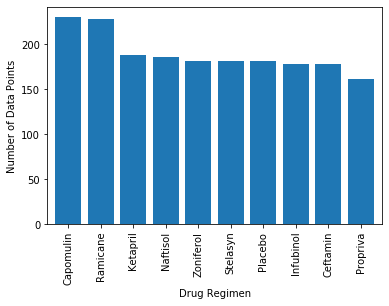

In [22]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
# creating series bar_data by value_count original merge_table
bar_data = merge_table['Drug Regimen'].value_counts()
pd_bar = bar_data.plot.bar(width=0.8) # set width to 0.8 to match default matplotlib width
pd_bar.set_xlabel('Drug Regimen')
pd_bar.set_ylabel('Number of Data Points')
plt.show()

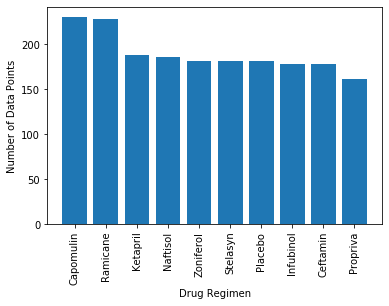

In [6]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot
# created regimens to not affect bar_data series and utilize index due to being in correct descending order for x-axis
regimens = bar_data
regimens_axis = regimens.index
plt.bar(regimens_axis,bar_data)
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.show()

## Pie plots

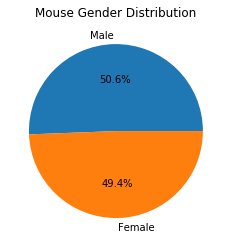

In [7]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
# create data for male and female count
pie_data = merge_table['Sex'].value_counts()
total_mice = merge_table['Mouse ID'].count()
male_mice = pie_data['Male']
female_mice = pie_data['Female']
percent_male = male_mice/total_mice
percent_female = female_mice/total_mice

pd_pie = pie_data.plot.pie(title='Mouse Gender Distribution',autopct='%1.1f%%',legend=False)
pd_pie.set_ylabel('')
plt.show()

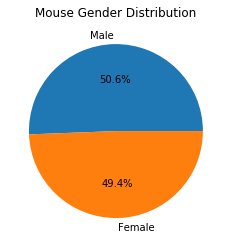

In [8]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(pie_data, labels=pie_data.index,autopct='%1.1f%%')
plt.title('Mouse Gender Distribution')
plt.show()

## Quartiles, outliers and boxplots

In [11]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. 
mouse_group = merge_table.groupby('Mouse ID')

def initial_final(x):
    column_names = {
        'Initial': float(x['Tumor Volume (mm3)'].head(1)),
        'Final': float(x['Tumor Volume (mm3)'].tail(1))}
    return pd.Series(column_names,index=['Initial','Final'])
mouse_group = mouse_group.apply(initial_final)

final_volume = pd.merge(mouse_group,merge_table,on='Mouse ID')
final_volume = final_volume.loc[:,['Mouse ID','Final','Drug Regimen']]
final_volume = final_volume.drop_duplicates()
final_volume = final_volume.sort_values('Final')
final_volume


,Mouse ID,Final,Drug Regimen
800,k403,22.050126,Ramicane
1383,s185,23.343598,Capomulin
990,m601,28.430964,Capomulin
1720,x401,28.484033,Capomulin
572,g791,29.128472,Ramicane
...,...,...,...
1483,t724,75.113288,Naftisol
956,m269,75.123690,Stelasyn
1171,p189,75.294936,Ketapril
919,l725,76.668817,Naftisol


In [12]:
# Create grouped series of average final volumes for selection of promising drugs
final_drug_group = final_volume.groupby('Drug Regimen').mean()
final_drug_group.columns = ['Average Final']
final_drug_group.sort_values('Average Final').head(10)
# selecting Ramicane, Capomulin, Propriva, and Ceftamin based on the best average final tumor volumes

,Average Final
Drug Regimen,
Ramicane,36.191390
Capomulin,36.667568
Propriva,56.736964
Ceftamin,57.753977
Infubinol,58.178246
Zoniferol,59.181258
Placebo,60.508414
Stelasyn,61.001707
Naftisol,61.205757


In [13]:
# Calculate the IQR and quantitatively determine if there are any potential outliers.
# running quantiles per drug, per quartile for easier editing and column additions
def quartiles(x):
    column_names = {
        'Lower Q': float(x['Final'].quantile(0.25)),
        'Upper Q': float(x['Final'].quantile(0.75))}
    return pd.Series(column_names,index=['Lower Q','Upper Q'])
final_qs = final_volume.groupby('Drug Regimen').apply(quartiles)
final_stats = pd.merge(final_drug_group,final_qs,on='Drug Regimen')
final_stats['IQR'] = final_stats['Upper Q'] - final_stats['Lower Q']
final_stats['Lower Bound'] = final_stats['Lower Q'] - (1.5*final_stats['IQR'])
final_stats['Upper Bound'] = final_stats['Upper Q'] + (1.5*final_stats['IQR'])
final_stats.sort_values('Average Final').head(4)

,Average Final,Lower Q,Upper Q,IQR,Lower Bound,Upper Bound
Drug Regimen,,,,,,
Ramicane,36.191390,31.560470,40.659006,9.098537,17.912664,54.306811
Capomulin,36.667568,32.377357,40.159220,7.781863,20.704562,51.832015
Propriva,56.736964,49.122969,62.570880,13.447911,28.951103,82.742746
Ceftamin,57.753977,48.722078,64.299830,15.577752,25.355450,87.666458


### Quantitative analysis
* The top 4 drugs by average final tumor volume are:
Ramicane, Capomulin, Propriva, and Ceftamin

* Based on the table above, there does not appear to be any outliers when comparing all the mice in each drug regimen

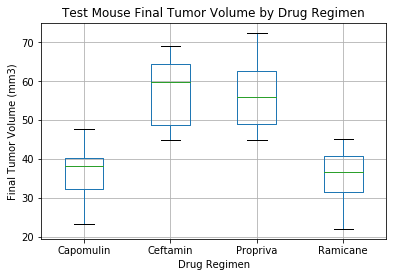

Boxplot confirms there were no outliers in the data for the top 4 drug regimens


In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# Drop rows of drugs not being used in boxplot
boxplot_df = final_volume.drop(final_volume.index[(final_volume['Drug Regimen'] != 'Ramicane') & 
                                                (final_volume['Drug Regimen'] != 'Capomulin') &
                                               (final_volume['Drug Regimen'] != 'Propriva') & 
                                               (final_volume['Drug Regimen'] != 'Ceftamin')])

boxplot = boxplot_df.boxplot(column='Final', by="Drug Regimen")
boxplot.set_ylabel('Final Tumor Volume (mm3)')
boxplot.set_title('Test Mouse Final Tumor Volume by Drug Regimen')
boxplot.get_figure().suptitle('')
plt.show()
print('Boxplot confirms there were no outliers in the data for the top 4 drug regimens')

## Line and scatter plots

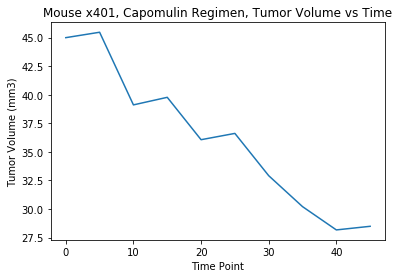

In [16]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
# Using Mouse x401
x401 = merge_table.drop(merge_table.index[(merge_table['Mouse ID'] != 'x401')])
plt.plot(x401['Timepoint'],x401['Tumor Volume (mm3)'])
plt.xlabel('Time Point')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Mouse x401, Capomulin Regimen, Tumor Volume vs Time')
plt.show()

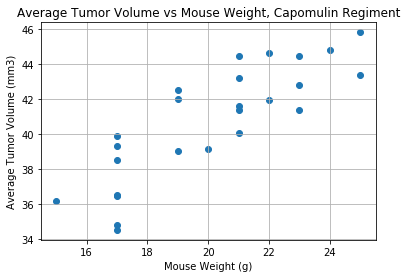

In [17]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
capomulin = merge_table.drop(merge_table.index[(merge_table['Drug Regimen'] != 'Capomulin')])
avg_volume = capomulin.groupby('Mouse ID').apply(lambda x: x['Tumor Volume (mm3)'].mean())
avg_volume = pd.DataFrame(avg_volume,columns=['Average Tumor Volume (mm3)'])
avg_volume = pd.merge(avg_volume,capomulin,on='Mouse ID').drop_duplicates(['Mouse ID']).reset_index(drop=True)
plt.scatter(avg_volume['Weight (g)'],avg_volume['Average Tumor Volume (mm3)'])
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')
plt.title('Average Tumor Volume vs Mouse Weight, Capomulin Regiment')
plt.grid(b=True,axis='both')
plt.show()

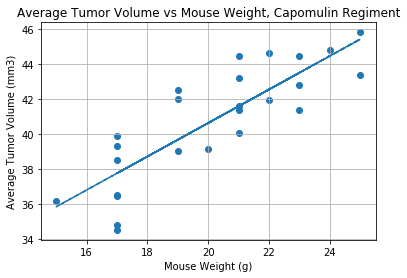

Correlation Coefficient for average tumor volume vs weight is 0.842
The linear regression model is Average Tumor Volume (mm3) = 0.95 * Mouse Weight (g) + 21.55


In [23]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
weight = avg_volume['Weight (g)']
volume = avg_volume['Average Tumor Volume (mm3)']
slope, v_int, r, p, std_err = st.linregress(weight,volume)
fit = slope * avg_volume['Weight (g)'] + v_int
plt.scatter(weight,volume)
plt.plot(weight,fit,'--')
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')
plt.title('Average Tumor Volume vs Mouse Weight, Capomulin Regiment')
plt.grid(b=True,axis='both')
plt.show()
r = round(r,3)
slope = round(slope,2)
v_int = round(v_int,2)
print(f'Correlation Coefficient for average tumor volume vs weight is {r}')
print(f'The linear regression model is Average Tumor Volume (mm3) = {slope} * Mouse Weight (g) + {v_int}')